# Лабораторная работа №1 по дисциплине "Системы обработки больших данных"
## Подключаем библиотеки и датасет. Определяем колонки по типу, выводим их, а также выполняем вывод части данных

In [1]:
# Import other modules not related to PySpark
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
from pyspark.sql import functions as F  # Importing necessary functions
# This helps auto print out the items without explixitly using 'print'
from pyspark.sql.functions import when, col
from pyspark.sql.functions import mean
from pyspark.sql.functions import avg, col, stddev, mean, min, max
from pyspark.sql.functions import percentile_approx, min, max, mean, stddev
from pyspark.sql.functions import count
from pyspark.sql.window import Window
import pyspark.sql.functions as F
from pyspark.sql.functions import length
from pyspark.sql.functions import lag
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import round
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline

In [2]:
# Import PySpark related modules
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct
from pyspark.sql.types import *

MAX_MEMORY = '8G'
# Initialize a spark session.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Pyspark guide") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()
filename_data = 'data/iran_201906_2_tweets_csv_hashed.csv'
# Load the main data set into pyspark data frame 
df = spark.read.csv(filename_data,header=True, mode="DROPMALFORMED", inferSchema=True)
from pyspark.sql.functions import col, array

df = df.drop("user_profile_description", "account_language", "tweet_text", "tweet_time", "tweet_client_name", "in_reply_to_userid", "in_reply_to_tweetid", "quoted_tweet_tweetid", "retweet_userid", "retweet_tweetid", "latitude", "longitude", "user_mentions", "poll_choices", "hashtags", "urls", "user_screen_name", "user_display_name", "user_profile_url")

df = df.withColumn("tweetid", col("tweetid").cast(LongType()))
df = df.withColumn("userid", col("userid").cast(LongType()))
df = df.withColumn("follower_count", col("follower_count").cast(IntegerType()))
df = df.withColumn("following_count", col("following_count").cast(IntegerType()))
df = df.withColumn("quote_count", col("like_count").cast(IntegerType()))
df = df.withColumn("reply_count", col("like_count").cast(IntegerType()))
df = df.withColumn("like_count", col("like_count").cast(IntegerType()))
df = df.withColumn("retweet_count", col("like_count").cast(IntegerType()))
df = df.withColumn("account_creation_date", col("account_creation_date").cast(DateType()))
df = df.withColumn("is_retweet", col("is_retweet").cast("boolean"))

print('Data frame type: ' + str(type(df)))

total_twitter_count = df.count()
print('Rows count:', total_twitter_count)

Data frame type: <class 'pyspark.sql.dataframe.DataFrame'>
Rows count: 7417013


### Выполняем разведочный анализ датасета с определением:

#### 1. Типы признаков в датасете:

In [3]:
print('Data overview')
df.printSchema()
print('Columns overview')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

Data overview
root
 |-- tweetid: long (nullable = true)
 |-- userid: long (nullable = true)
 |-- user_reported_location: string (nullable = true)
 |-- follower_count: integer (nullable = true)
 |-- following_count: integer (nullable = true)
 |-- account_creation_date: date (nullable = true)
 |-- tweet_language: string (nullable = true)
 |-- is_retweet: boolean (nullable = true)
 |-- quote_count: integer (nullable = true)
 |-- reply_count: integer (nullable = true)
 |-- like_count: integer (nullable = true)
 |-- retweet_count: integer (nullable = true)

Columns overview


,Column Name,Data type
0,tweetid,bigint
1,userid,bigint
2,user_reported_location,string
3,follower_count,int
4,following_count,int
5,account_creation_date,date
6,tweet_language,string
7,is_retweet,boolean
8,quote_count,int
9,reply_count,int


##### После анализа фрейма было решено оставить 12 колонок для осуществления анализа. Разберем типы признаков:
1. tweetid (целое число): Это идентификатор твита. Категориальный признак и является уникальным идентификатором для каждого твита.

2. userid (целое число): Это идентификатор пользователя твиттера. Тоже категориальный признак, и, как и в случае с tweetid, он представляет уникального пользователя.

3. user_reported_location (строка): Это местоположение, указанное пользователем. Категориальный признак, представляющий текстовую метку местоположения пользователя.

4. follower_count (целое число): Количество подписчиков у пользователя. Это количественный (непрерывный) признак, так как это число, которое может принимать широкий диапазон значений.

5. following_count (целое число): Количество пользователей, на которых подписан данный пользователь. Тоже количественный признак.

6. account_creation_date (дата): Дата создания учетной записи пользователя. Является категориальным признаком.

7. tweet_language (строка): Язык твита. Категориальный признак, представляющий язык твита, например, "en" для английского.

8. is_retweet (логическое значение): Это булевый признак, представляющий, является ли твит ретвитом или нет.

9. quote_count (целое число): Количество цитирований для указанного твита. Количественный признак.

10. reply_count (целое число): Количество ответов для указанного твита. Количественный признак.

11. like_count (целое число): Количество лайков для указанного твита. Количественный признак.

12. retweet_count (целое число): Количество ретвитов для указанного твита. Количественный признак.

#### 2. Выявление пропущенных значений и их устранение:

##### Определяем пропущенные значения:

In [4]:
string_columns = ['user_reported_location','account_creation_date','tweet_language', 'is_retweet']
numeric_columns = ['tweetid', 'userid', 'follower_count', 'following_count', "quote_count", "reply_count", "like_count", "retweet_count"]

def view_missing_values_in_columns(string_columns, numeric_columns):
    missing_values = {}
    for index, column in enumerate(df.columns):
        if column in string_columns:
            missing_count = df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
        else: 
            missing_count = df.where(col(column).isin([None,np.nan]) | col(column).isNull()).count()
        missing_values.update({column:missing_count})
    
    return missing_values

pd.DataFrame.from_dict([view_missing_values_in_columns(string_columns, numeric_columns)])

,tweetid,userid,user_reported_location,follower_count,following_count,account_creation_date,tweet_language,is_retweet,quote_count,reply_count,like_count,retweet_count
0,5233116,5823087,4813192,6235316,6359126,6359349,4935972,6705323,7109808,7109808,7109808,7109808


##### Осуществляем удаление найденных пропущенных значений:

In [5]:
df = df.dropna()
print('Устранение пропущенных значений прошло успешно')

Устранение пропущенных значений прошло успешно


##### Проверяем наличие пропущенных значений после их удаления:

In [6]:
pd.DataFrame.from_dict([view_missing_values_in_columns(string_columns, numeric_columns)])

,tweetid,userid,user_reported_location,follower_count,following_count,account_creation_date,tweet_language,is_retweet,quote_count,reply_count,like_count,retweet_count
0,0,0,0,0,0,0,0,0,0,0,0,0


#### 3. Определение выбросов и их устранение:

##### После обработки пропущенных значений формируем статистических данных для числовых столбцов датафрейма, чтобы определить оставшееся количество строк в фрейме:

In [7]:
df.select(df.follower_count, df.following_count, df.quote_count, df.reply_count, df.like_count, df.retweet_count).describe().toPandas()

,summary,follower_count,following_count,quote_count,reply_count,like_count,retweet_count
0,count,158349,158349,158349,158349,158349,158349
1,mean,35961.50688037184,5216.120619643951,5.235164099552255,5.235164099552255,5.235164099552255,5.235164099552255
2,stddev,48640.11318936038,4095.52211184446,45.96468987473596,45.96468987473596,45.96468987473596,45.96468987473596
3,min,0,9,0,0,0,0
4,max,158248,12022,3508,3508,3508,3508


##### Осуществим обнаружение и удаление выбросов методом межквартильного интервала (Нахождение 25% и 75% квартилей, межквартильного диапазона):
##### Данные колонок "quote_count", "reply_count", "like_count", "retweet_count" решено было не удалять, т.к. во всех датасетах это приводит к тому, что все уходит по нулям, т.к. на большинстве записей нет никаких реакций.

In [8]:
outlier_columns = ['follower_count', 'following_count']
for column in outlier_columns:
    Q1 = df.approxQuantile(column, [0.25], relativeError=0)[0]
    Q3 = df.approxQuantile(column, [0.75], relativeError=0)[0]
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df.filter(col(column).between(lower_bound, upper_bound))

df.select(['follower_count', 'following_count', 'quote_count', 'reply_count', 'like_count', 'retweet_count']).describe().toPandas()

,summary,follower_count,following_count,quote_count,reply_count,like_count,retweet_count
0,count,133110,133110,133110,133110,133110,133110
1,mean,16061.520629554503,4814.536270753512,6.134918488468184,6.134918488468184,6.134918488468184,6.134918488468184
2,stddev,3595.6887477427713,4154.536709299581,50.041604819537135,50.041604819537135,50.041604819537135,50.041604819537135
3,min,9847,174,0,0,0,0
4,max,20874,12022,3508,3508,3508,3508


##### Повторно формируем "ящики с усами" (boxspot-ы) для проверки работоспособности метода межквартильного интервала:

<Axes: >

Text(0.5, 1.0, 'Boxplot of follower_count')

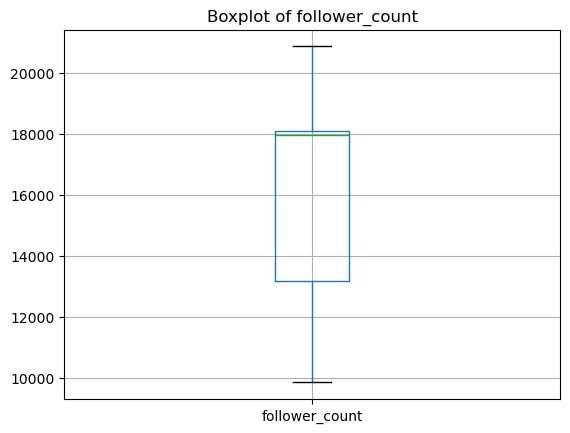

<Axes: >

Text(0.5, 1.0, 'Boxplot of following_count')

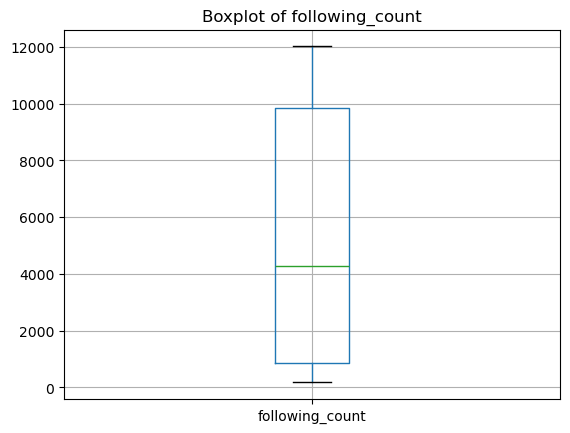

In [9]:
pandas_df = df.toPandas()
for column in outlier_columns:
    pandas_df.boxplot(column=column)
    plt.title(f'Boxplot of {column}')
    plt.show()

#### 4. Расчет статистических показателей признаков (средних, квартилей и т.д.):

##### Выведем типы признаков:

In [10]:
print('Columns overview')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

Columns overview


,Column Name,Data type
0,tweetid,bigint
1,userid,bigint
2,user_reported_location,string
3,follower_count,int
4,following_count,int
5,account_creation_date,date
6,tweet_language,string
7,is_retweet,boolean
8,quote_count,int
9,reply_count,int


##### Для реализации этого пункта было решено разобрать категориальные, бинарные и количественные признаки:

##### Обработаем колонки количественных признаков, а также по одной колонке категориального и одной колонки бинарного признака. Начнём с количественных признаков: 

##### Статистические показатели обширны, вот основные из них:
1. Среднее (Mean): Обычно является первым показателем, который рассчитывается для числовых данных. Среднее значение предоставляет информацию о центре распределения данных.

2. Медиана (Median): Это значение, которое делит ваш набор данных на две равные части. Она устойчива к выбросам в данных и используется для оценки "среднего" значения, если данные имеют асимметричное распределение.

3. Квартили (Quartiles): Квартили представляют собой три точки данных, которые делят упорядоченный набор данных на четыре равные части. 25-й квартиль - это значение, которое меньше или равно 25% данных, а 75-й квартиль - это значение, которое меньше или равно 75% данных.

4. Мода (Mode): Значение, которое встречается наиболее часто в вашем наборе данных. Мода полезна для определения наиболее распространенных значений в категориальных данных.

5. Стандартное отклонение (Standard Deviation): Это мера разброса данных относительно их среднего значения. Она предоставляет информацию о том, насколько разнообразны значения в вашем наборе данных.

6. Диапазон значений (Range): Простое измерение, которое показывает разницу между самым большим и самым маленьким значениями в наборе данных.

7. Квантили (Quantiles): Квантили обобщают понятие квартиля. В то время как квартили делят данные на четыре равные части, квантили позволяют делить данные на более произвольное количество частей.

In [11]:
def calculate_statistics(df, columns):
    statistics = {'Statistic': ['Mean', 'Median', 'Mode', 'Standard Deviation', 'Range', '25th Quantile', '50th Quartiles', '75th Quantile']}

    for column in columns:
        mode_column = df.groupBy(column).count().sort(F.col("count").desc()).select(column).limit(1).collect()[0][0]

        column_values = [
            df.agg({column: "avg"}).collect()[0][0],  # среднее значение
            df.approxQuantile(column, [0.5], 0.001)[0],  # медиана
            mode_column,  # мода
            df.agg({column: "stddev"}).collect()[0][0],  # стандартное отклонение
            df.agg({column: 'max'}).collect()[0][0] - df.agg({column: 'min'}).collect()[0][0],  # диапазон
            df.approxQuantile(column, [0.25], 0.001)[0],  # 25-й квантиль
            df.approxQuantile(column, [0.50], 0.001)[0],  # 50-й квантиль
            df.approxQuantile(column, [0.75], 0.001)[0]   # 75-й квантиль
        ]
        
        statistics[f'{column}'] = column_values

    # Создаем DataFrame из словаря
    statistics_df = pd.DataFrame(statistics)

    return statistics_df

# Список столбцов для подсчета статистики
columns = ['follower_count', 'following_count', 'quote_count', 'reply_count', 'like_count', 'retweet_count']

# Получаем DataFrame со статистикой
result_df = calculate_statistics(df, columns)

# Выводим DataFrame
print(result_df)

            Statistic  follower_count  following_count  quote_count  \
0                Mean    16061.520630      4814.536271     6.134918   
1              Median    17956.000000      4278.000000     0.000000   
2                Mode    17956.000000      4278.000000     0.000000   
3  Standard Deviation     3595.688748      4154.536709    50.041605   
4               Range    11027.000000     11848.000000  3508.000000   
5       25th Quantile    13172.000000       848.000000     0.000000   
6      50th Quartiles    17956.000000      4278.000000     0.000000   
7       75th Quantile    18099.000000      9861.000000     1.000000   

   reply_count   like_count  retweet_count  
0     6.134918     6.134918       6.134918  
1     0.000000     0.000000       0.000000  
2     0.000000     0.000000       0.000000  
3    50.041605    50.041605      50.041605  
4  3508.000000  3508.000000    3508.000000  
5     0.000000     0.000000       0.000000  
6     0.000000     0.000000       0.000000  


##### Категориальные признаки расчитываются с использованием количественных признаков. В данном случае расчитываются:
1. Количество (count) - Указывает какое количество значений имеется в колонке.

2. Проценты (percentile) - Количественный показатель по определенной части категориального признака в виде процентов (в нашем случае: 25%, 50%, 75% и 95%).

3. Минимум (min) - Минимальный количественный показатель категориального признака.

4. Максимум (max) - Максимальный количественный показатель категориального признака.

5. Среднее (Mean) - Среднее значение количественных показателей категориального признака.

6. Стандартное отклонение (stddev) - Мера разброса данных относительно среднего значения количественных показателей категориального признака.

In [12]:
all_tweet_languages = df.groupBy("tweet_language").count().collect()

language_followers_statistic_df = []

for row in all_tweet_languages:
    tweet_language = row["tweet_language"]
    count = row["count"]
    stat_dict = {'tweet_language': tweet_language, 'count': count}

    language_followers_df = df.select(df.follower_count).filter(df.tweet_language == tweet_language)
    stats = language_followers_df.select(
        F.percentile_approx(df.follower_count, [0.25, 0.5, 0.75, 0.95], 1000000).alias("percentiles"),
        F.min(df.follower_count).alias('min'),
        F.max(df.follower_count).alias('max'),
        F.mean(df.follower_count).alias('mean'),
        F.stddev(df.follower_count).alias('stddev')
    ).collect()[0]

    stat_dict['25th percentile'] = stats['percentiles'][0]
    stat_dict['50th percentile'] = stats['percentiles'][1]
    stat_dict['75th percentile'] = stats['percentiles'][2]
    stat_dict['95th percentile'] = stats['percentiles'][3]
    stat_dict['min'] = stats['min']
    stat_dict['max'] = stats['max']
    stat_dict['mean'] = stats['mean']
    stat_dict['stddev'] = stats['stddev']

    language_followers_statistic_df.append(stat_dict)

language_followers_statistic_df = pd.DataFrame(language_followers_statistic_df)
language_followers_statistic_df

,tweet_language,count,25th percentile,50th percentile,75th percentile,95th percentile,min,max,mean,stddev
0,en,1357,11976,17956,18099,18099,9847,20874,15749.151069,3049.399162
1,ro,2,13172,13172,18099,18099,13172,18099,15635.500000,3483.915111
2,und,19577,13403,17956,18099,20874,9847,20874,16877.778771,3357.634856
3,ur,54,17956,17956,18099,20874,10238,20874,18107.685185,2407.374016
4,tl,4,9847,17956,18099,18099,9847,18099,16000.250000,4102.720510
5,in,19,11976,17956,18099,20874,9847,20874,15466.105263,3877.184257
6,es,21,17956,17956,18099,18099,9847,20256,16493.428571,3156.937877
7,ar,62333,17956,17956,20256,20874,9847,20874,18339.626137,2067.378563
8,ca,3,10805,18099,18099,18099,10805,18099,15667.666667,4211.192863
9,iw,2,13172,13172,13172,13172,13172,13172,13172.000000,0.000000


##### Бинарный признак:

1. Количество (count) - Указывает какое количество значений имеется в колонке

2. Проценты (percentile) - Отношение количества значений в процентах данного показателя от обшего.

In [13]:
# Подсчёт количества значений "true" и "false"
true_false_counts = df.groupBy("is_retweet").count()

# Добавление столбца с процентным соотношением
total_count = df.count()
true_false_counts_with_percentage = true_false_counts.withColumn("percentage", F.col("count") / total_count * 100)

true_false_counts_with_percentage.show()

+----------+-----+------------------+
|is_retweet|count|        percentage|
+----------+-----+------------------+
|      true|67408|50.640823379160096|
|     false|65702|49.359176620839904|
+----------+-----+------------------+



#### 5. Визуализацией распределения наиболее важных признаков:

1. Вывод 5 самых популярных местоположений по публикации твитов:

Топ 5 местоположений твитов:


/tmp/ipykernel_18469/1106387697.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  xsticks_label = axs[0].set_xticklabels(highest_twitter_df['user_reported_location'], rotation='vertical', fontsize='small')


,user_reported_location,count,percentage
0,جنوب لبنان تغريداتي بالمفضله,41013,30.811359
1,A̷R̷A̷Q̷ (Nasiriyah),19623,14.741943
2,ایـران ، طهــران ، شمیـــران,16009,12.026895
3,زیر آسمون خدا,12336,9.267523
4,عند حسن العاقبة,11610,8.722110
0,others,32519,24.430171


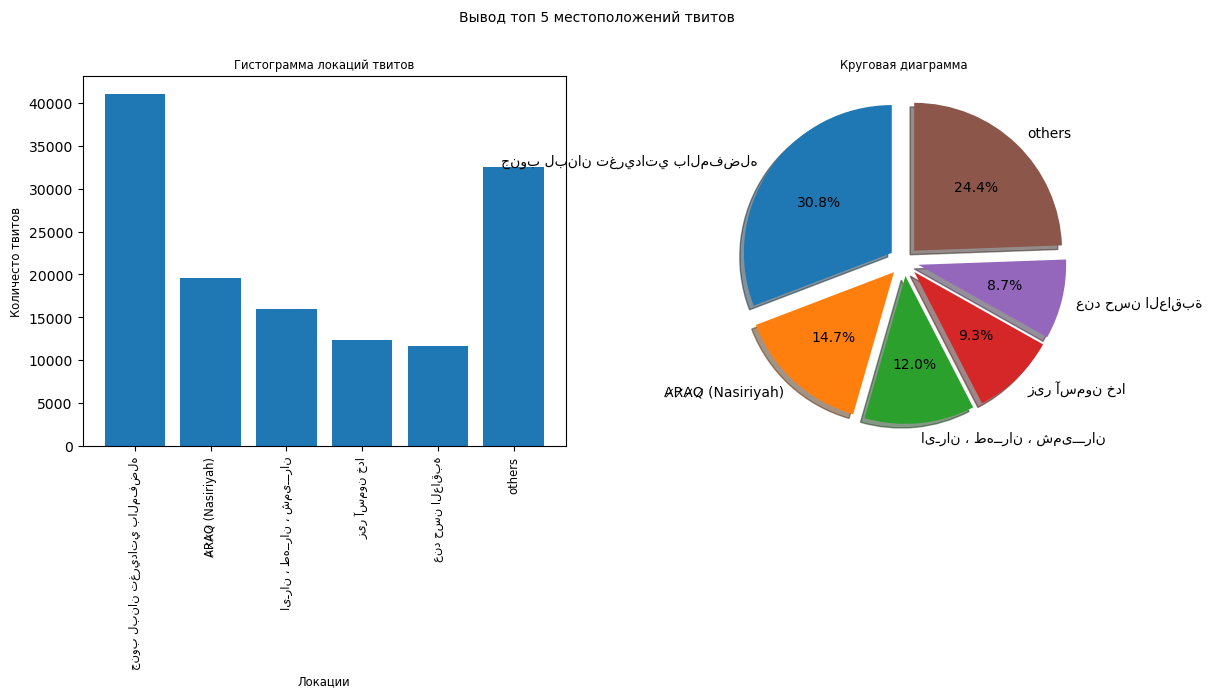

In [14]:
total_twitter_count = df.count()
highest_twitter_df = df.select(df.user_reported_location) \
    .groupBy(df.user_reported_location) \
    .count() \
    .orderBy("count", ascending=False) \
    .limit(5) \
    .toPandas()


highest_twitter_df['percentage'] = highest_twitter_df['count'] \
    / total_twitter_count * 100

others = {
    'user_reported_location': 'others', 
    'count': total_twitter_count - np.sum(highest_twitter_df['count']), 
    'percentage': 100 - np.sum(highest_twitter_df['percentage'])
}

highest_twitter_df = pd.concat([highest_twitter_df,pd.DataFrame.from_dict([others])])


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(0.35))

plot0 = axs[0].bar(x=highest_twitter_df['user_reported_location'], height=highest_twitter_df['count'])
title0 = axs[0].set_title('Гистограмма локаций твитов', fontsize='small')
xlabel0 = axs[0].set_xlabel('Локации', fontsize='small')
ylabel0 = axs[0].set_ylabel('Количесто твитов', fontsize='small')
xsticks_label = axs[0].set_xticklabels(highest_twitter_df['user_reported_location'], rotation='vertical', fontsize='small')
explode = (0.1,) * len(highest_twitter_df['user_reported_location'])
title1 = axs[1].set_title('Круговая диаграмма', fontsize='small')
plot1 = axs[1].pie(x=highest_twitter_df['percentage'],
                   labels=highest_twitter_df['user_reported_location'],
                   autopct='%1.1f%%',
                   shadow=True,
                   explode=explode,
                   startangle=90,
                   radius=1)

print('Топ 5 местоположений твитов:')
highest_twitter_df

text = fig.text(0.5, 1.02, 'Вывод топ 5 местоположений твитов', ha='center', va='top', transform=fig.transFigure)

2. Диграмма распределения местоположений твитов в зависимости является это ли ретвитом или нет:

/tmp/ipykernel_18469/2362917482.py:25: UserWarning: Glyph 127470 (\N{REGIONAL INDICATOR SYMBOL LETTER I}) missing from current font.
  a = fig.tight_layout()
/tmp/ipykernel_18469/2362917482.py:25: UserWarning: Glyph 127479 (\N{REGIONAL INDICATOR SYMBOL LETTER R}) missing from current font.
  a = fig.tight_layout()
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127470 (\N{REGIONAL INDICATOR SYMBOL LETTER I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127479 (\N{REGIONAL INDICATOR SYMBOL LETTER R}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


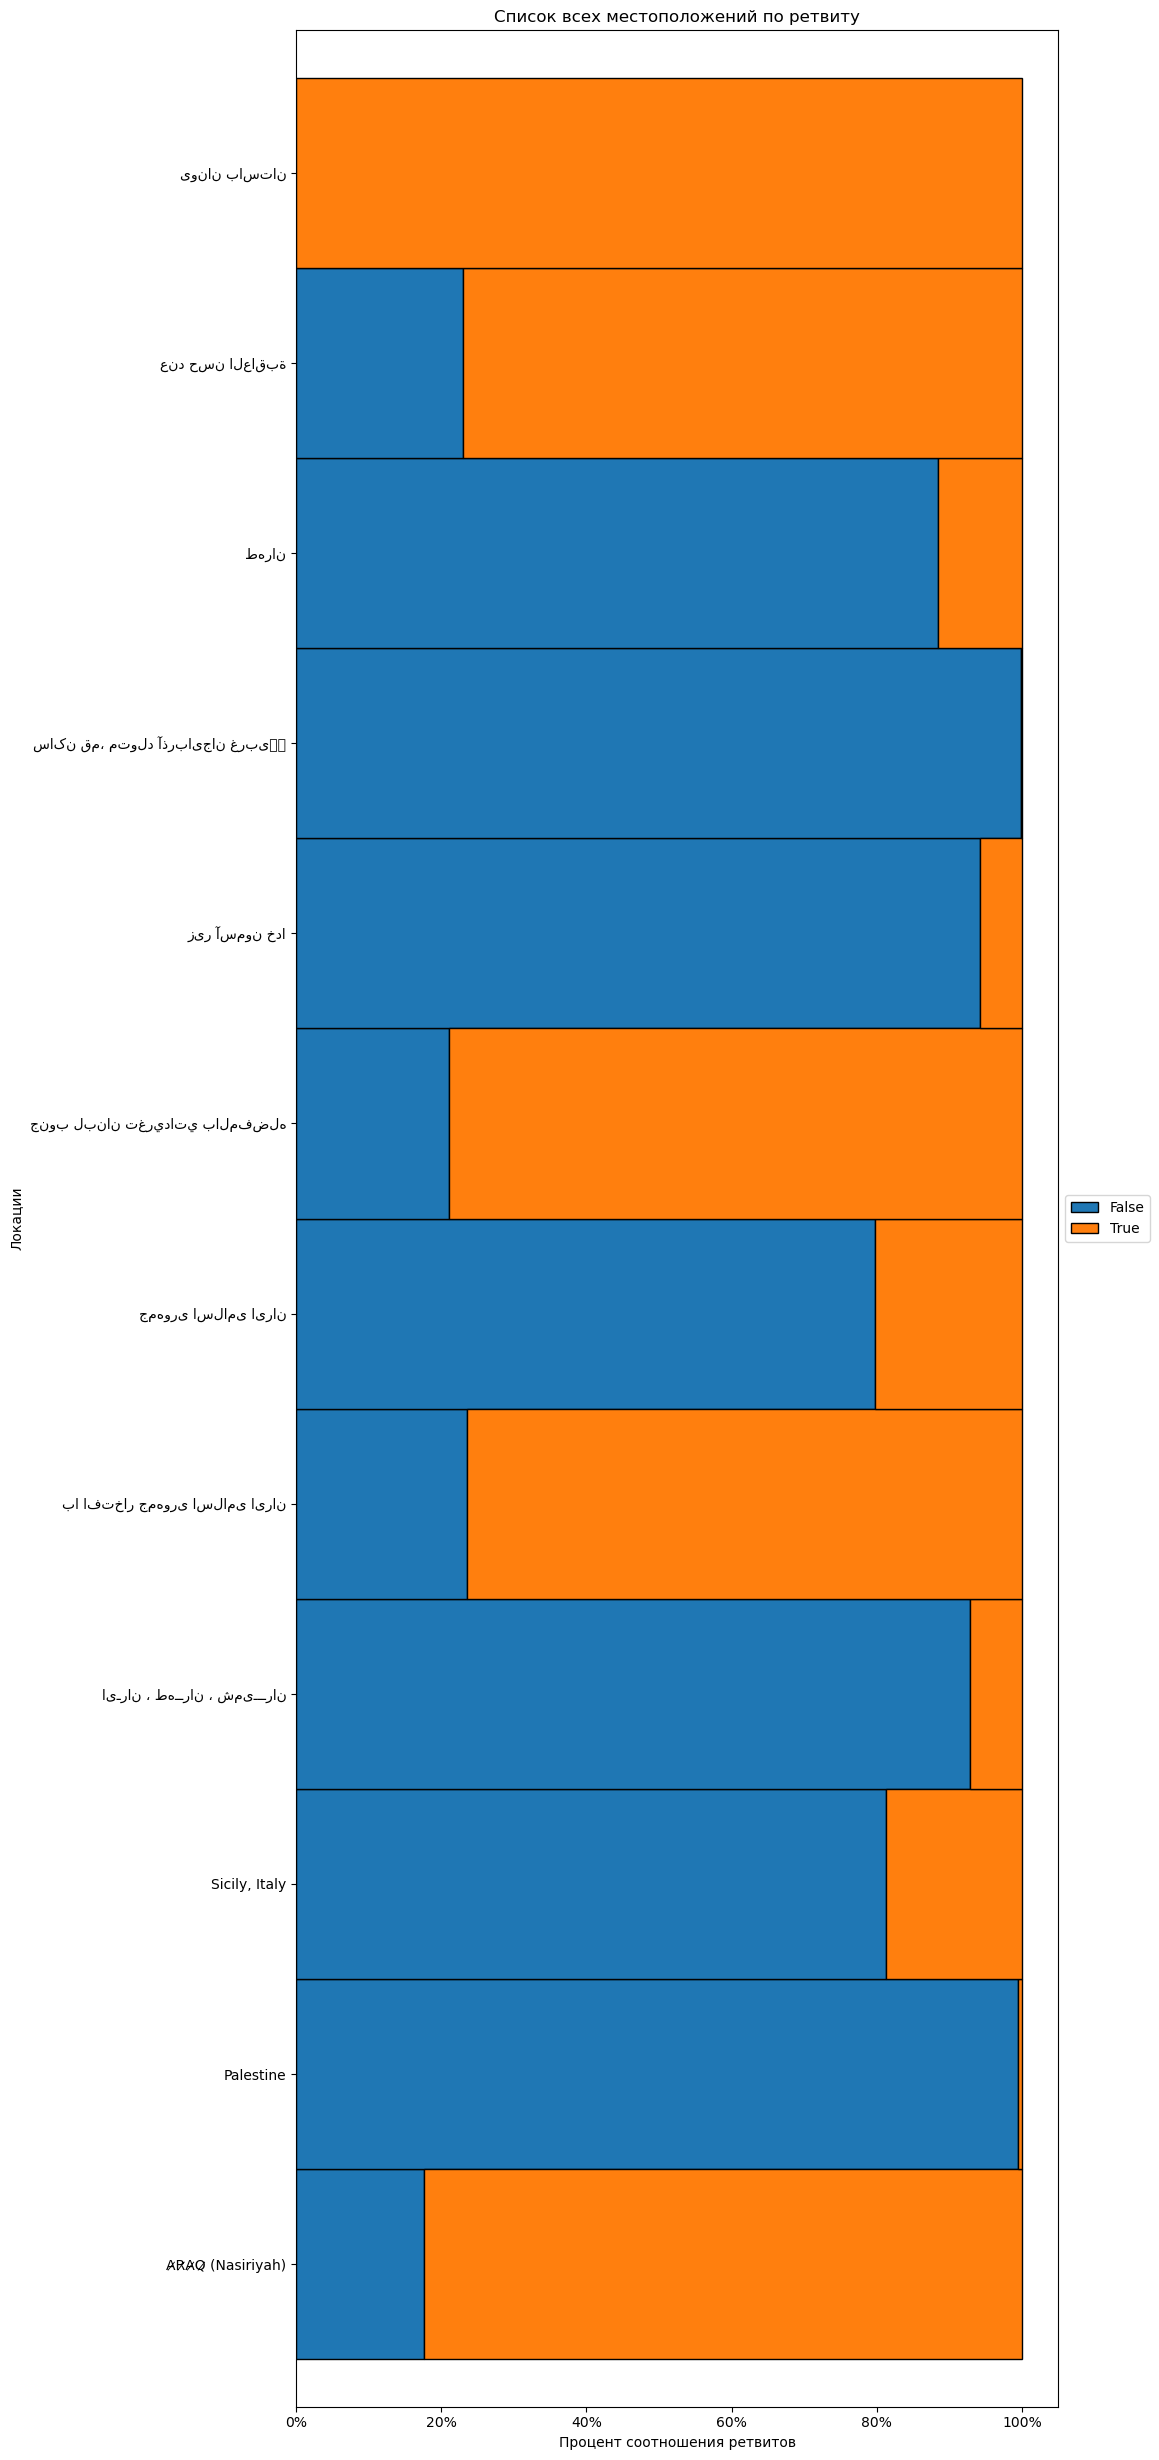

In [15]:
location_by_retweet_df = df.groupBy(df.user_reported_location, df.is_retweet).count().toPandas()

is_retweet = location_by_retweet_df['is_retweet'].unique()

fig = plt.figure(figsize=(12, 25))
grid_size = (1,1);
ax = plt.subplot2grid(grid_size, (0,0), colspan=1, rowspan=1)
plot = location_by_retweet_df.groupby(['user_reported_location', 'is_retweet'],group_keys=True).agg(np.mean) \
    .groupby(level=0,group_keys=False) \
    .apply(
        lambda x: 100 * x / x.sum()).unstack().plot(kind='barh', 
                                                    stacked=True, 
                                                    width=1,
                                                    edgecolor='black', 
                                                    ax=ax, 
                                                    title='Список всех местоположений по ретвиту')
ylabel = plt.ylabel('Локации');
xlabel = plt.xlabel('Процент соотношения ретвитов');
legend = plt.legend(
    sorted(is_retweet), loc='center left', bbox_to_anchor=(1.0, 0.5)
)
param_update = plt.rcParams.update({'font.size': 20});
ax = plt.gca()
formatter = ax.xaxis.set_major_formatter(mtick.PercentFormatter());
a = fig.tight_layout()
plt.show()

3. Распределение количества подписчиков на всех пользователей отфильтрованного фрейма:

(array([17248., 12336.,     0., 24153.,  1596.,     0.,     0., 52623.,
            0., 25154.]),
 array([ 9847. , 10949.7, 12052.4, 13155.1, 14257.8, 15360.5, 16463.2,
        17565.9, 18668.6, 19771.3, 20874. ]),
 <BarContainer object of 10 artists>)

Text(0.5, 1.0, 'Распределение количества подписчиков')

Text(0.5, 0, 'Количество подписчиков')

Text(0, 0.5, 'Частота')

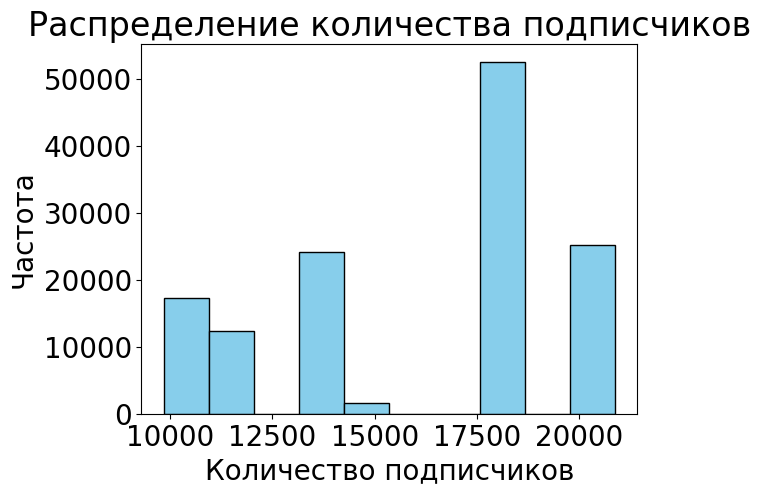

In [16]:
follower_counts = df.select("follower_count").toPandas()
plt.hist(follower_counts, bins=10, color='skyblue', edgecolor='black')
plt.title('Распределение количества подписчиков')
plt.xlabel('Количество подписчиков')
plt.ylabel('Частота')
plt.show()

4. Среднее количество подписчиков в зависимости от местоположения твита (список был создан для возможности создания графика):

<Axes: xlabel='user_reported_location'>

/opt/conda/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: Glyph 127470 (\N{REGIONAL INDICATOR SYMBOL LETTER I}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: Glyph 127479 (\N{REGIONAL INDICATOR SYMBOL LETTER R}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127470 (\N{REGIONAL INDICATOR SYMBOL LETTER I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127479 (\N{REGIONAL INDICATOR SYMBOL LETTER R}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


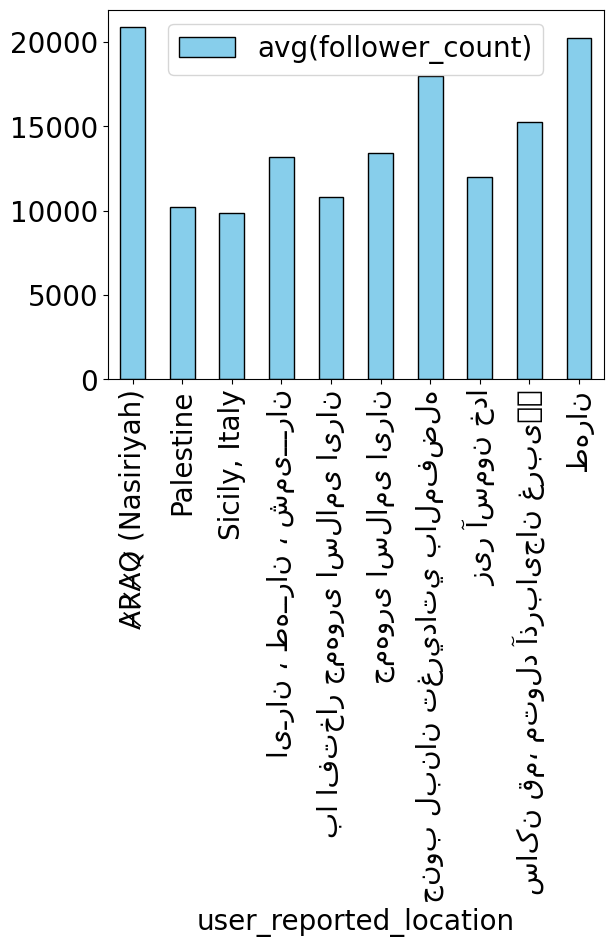

In [17]:
# Выберем 10 уникальных значений из столбца user_reported_location
unique_locations = df.select('user_reported_location').distinct().orderBy('user_reported_location').limit(10)

# Поместим эти значения в список
selected_locations = [row.user_reported_location for row in unique_locations.collect()]

# Теперь используем этот список в качестве фильтра для DataFrame
filtered_df = df.filter(df.user_reported_location.isin(selected_locations))

df.select(df.user_reported_location, df.follower_count) \
    .filter(df.user_reported_location.isin(selected_locations)) \
    .groupBy(df.user_reported_location) \
    .avg('follower_count') \
    .toPandas() \
    .sort_values(by='user_reported_location') \
    .plot.bar(column="avg(follower_count)", x='user_reported_location', rot=90, color='skyblue', edgecolor='black')


5. Среднее число подписчиков на каждую страну проживания пользователя:

<Axes: ylabel='tweet_language'>

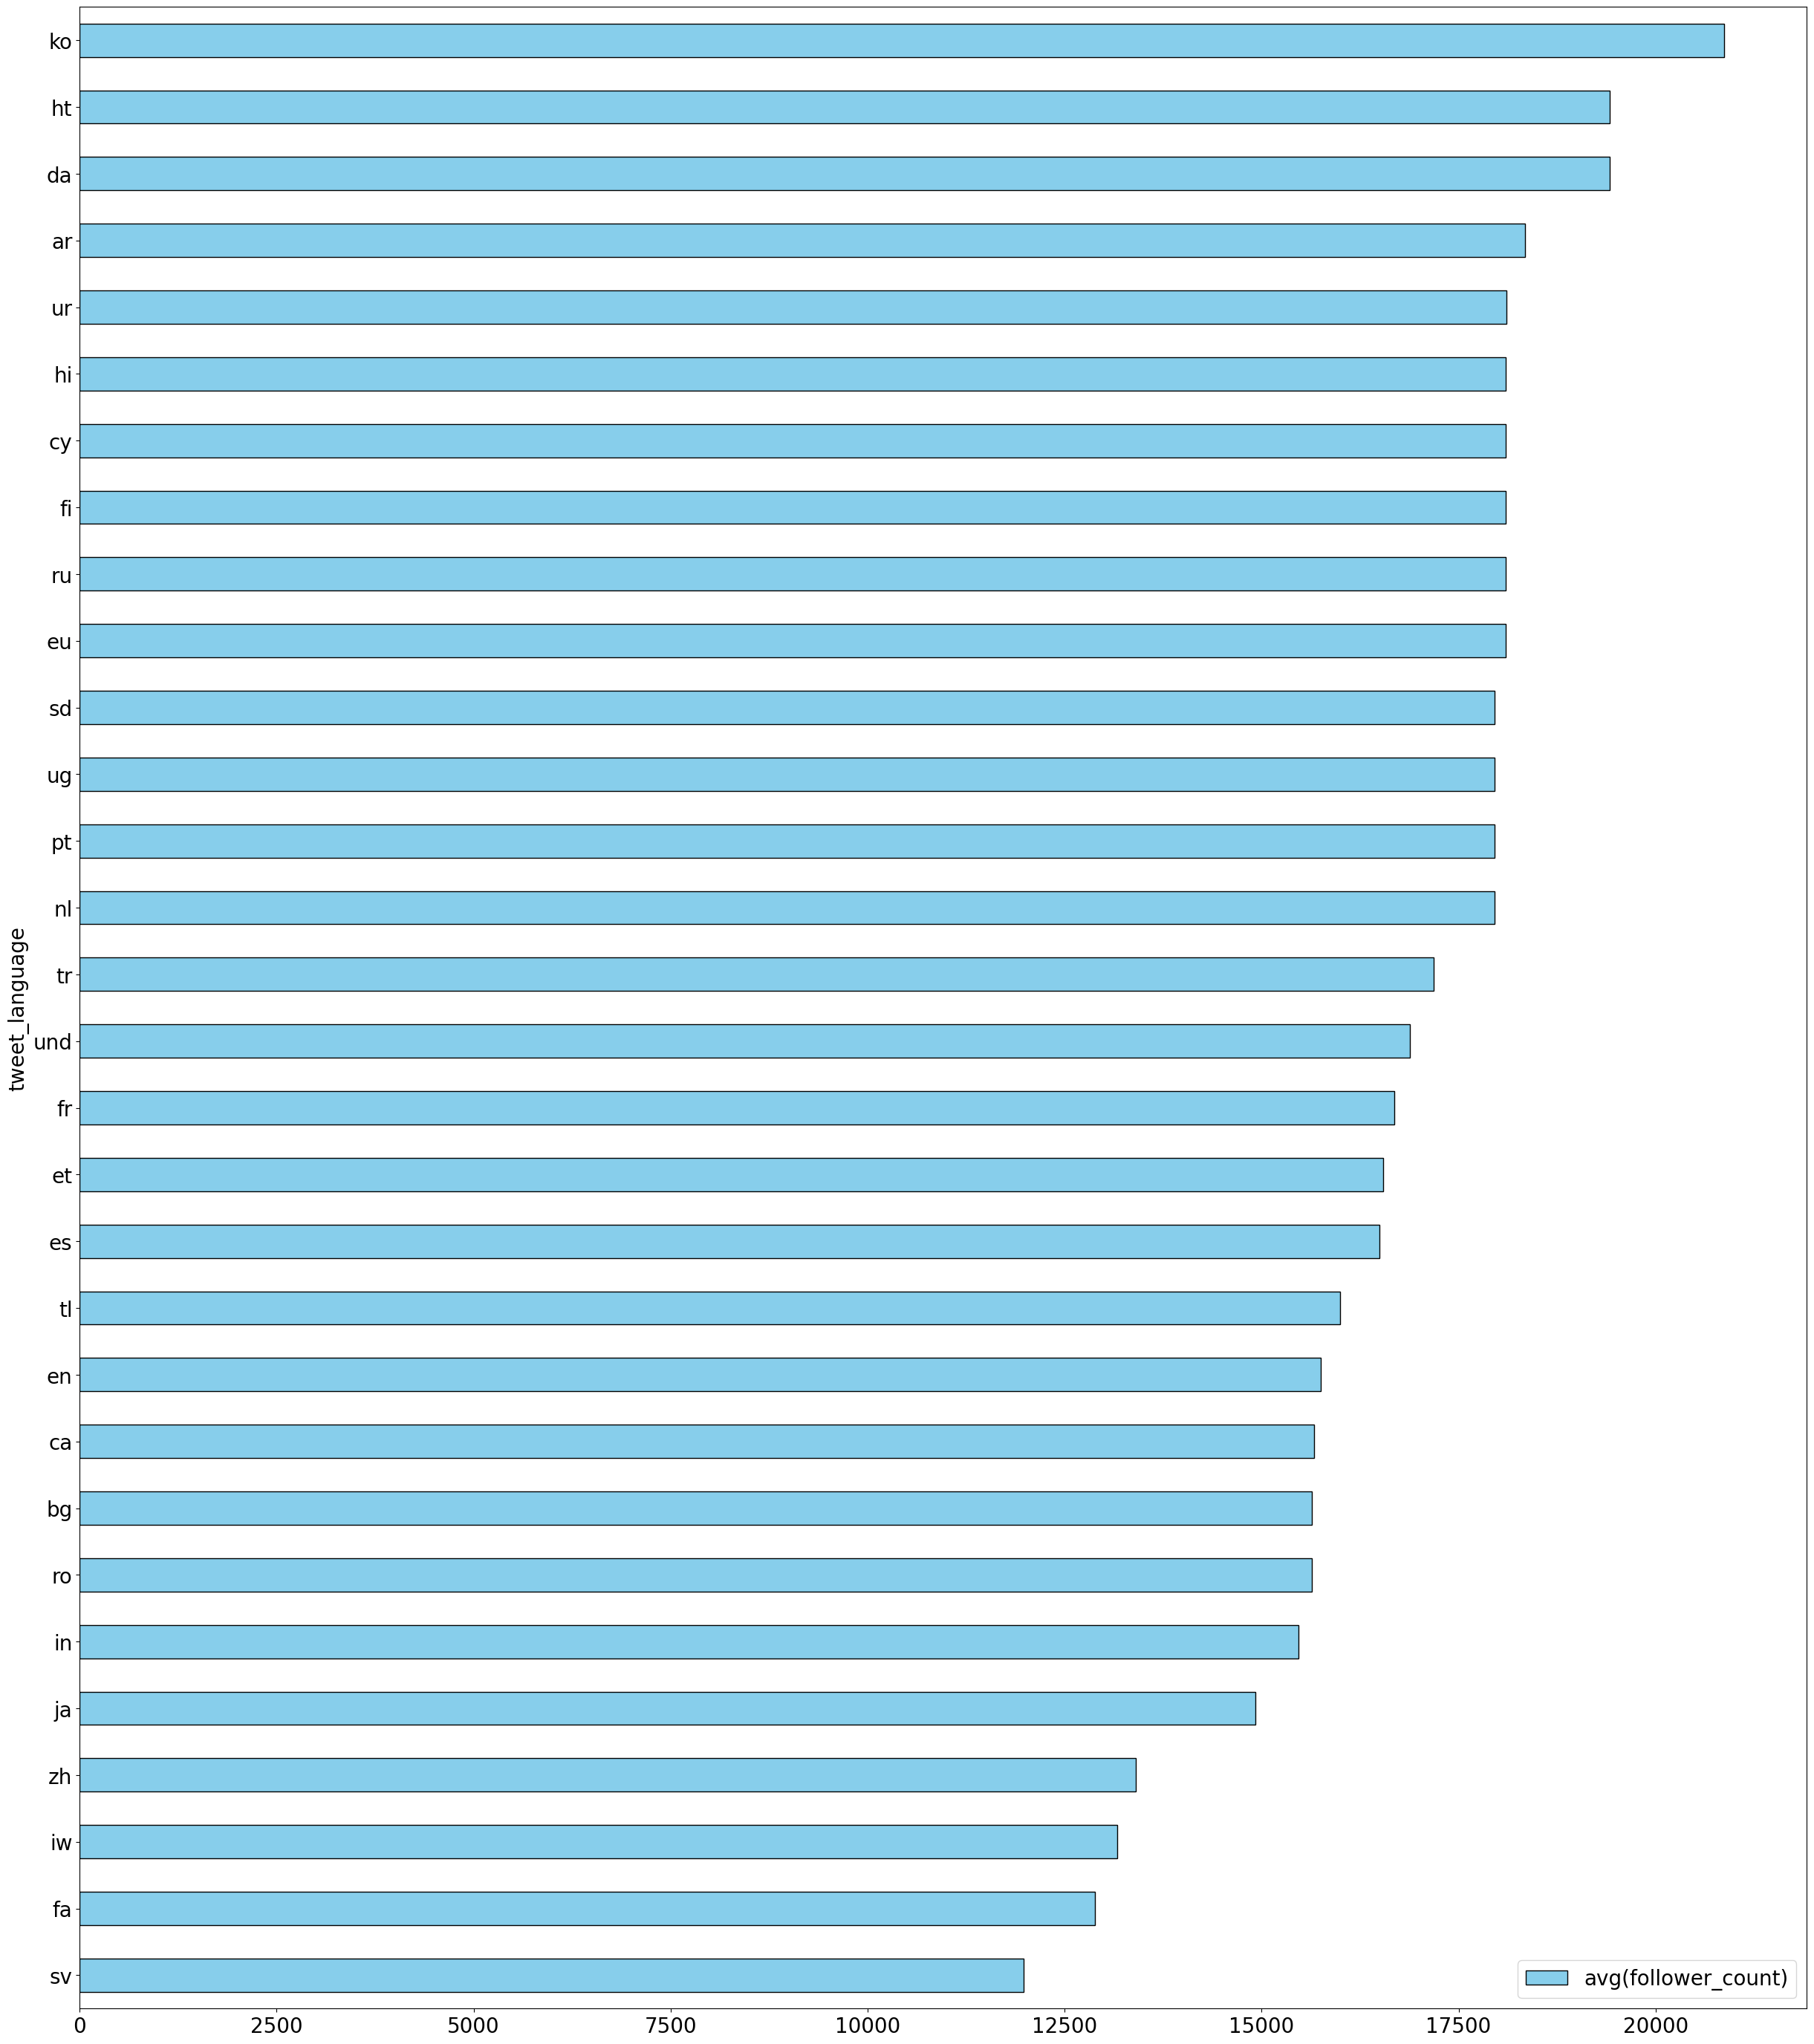

In [18]:
df.select(df.tweet_language, df.follower_count) \
    .groupBy(df.tweet_language) \
    .avg('follower_count') \
    .toPandas() \
    .sort_values(by='avg(follower_count)') \
    .plot.barh(column="avg(follower_count)", x='tweet_language', figsize=(30,35), color='skyblue', edgecolor='black')

6. Количество пользователей с конкретной страны, зарегестированные в определенную дату

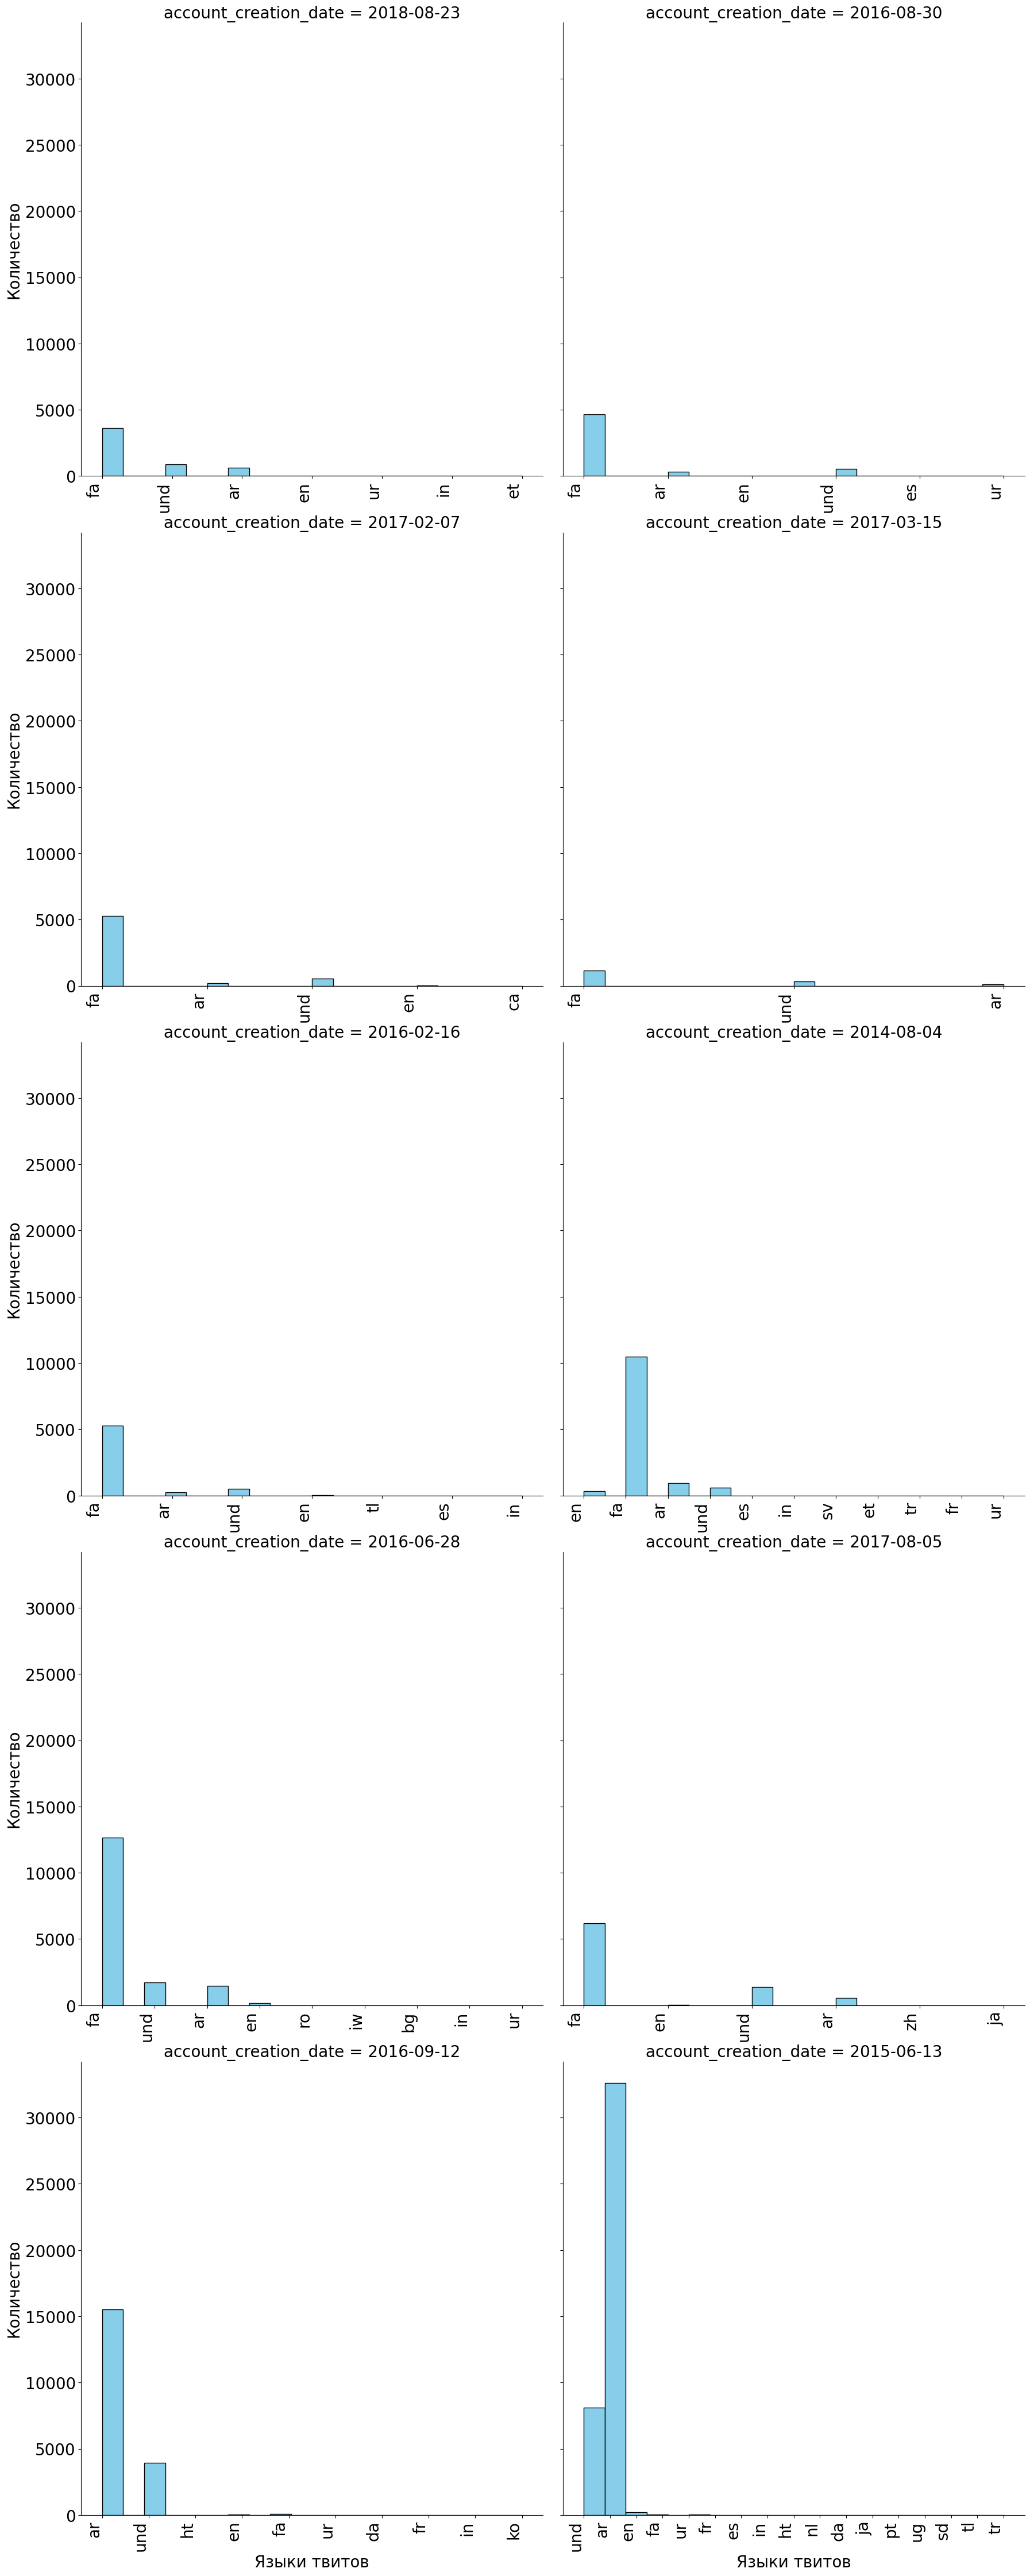

In [19]:
# Настройка графика
g = sns.FacetGrid(filtered_df.toPandas(), col='account_creation_date', col_wrap=2, height=9, sharex=False)
g.map(plt.hist, 'tweet_language', bins=20, color='skyblue', edgecolor='black')
g.set_xticklabels(rotation=90, ha='right')
g.set_axis_labels("Языки твитов", "Количество")
plt.show()

7. Выводим 5 диаграмм рассеивания для 5 популярных языков по количествам подписок-подписчиков

<Axes: xlabel='follower_count', ylabel='following_count'>

Text(0.5, 1.0, 'ar')

<Axes: xlabel='follower_count', ylabel='following_count'>

Text(0.5, 1.0, 'fa')

<Axes: xlabel='follower_count', ylabel='following_count'>

Text(0.5, 1.0, 'und')

<Axes: xlabel='follower_count', ylabel='following_count'>

Text(0.5, 1.0, 'en')

<Axes: xlabel='follower_count', ylabel='following_count'>

Text(0.5, 1.0, 'ur')

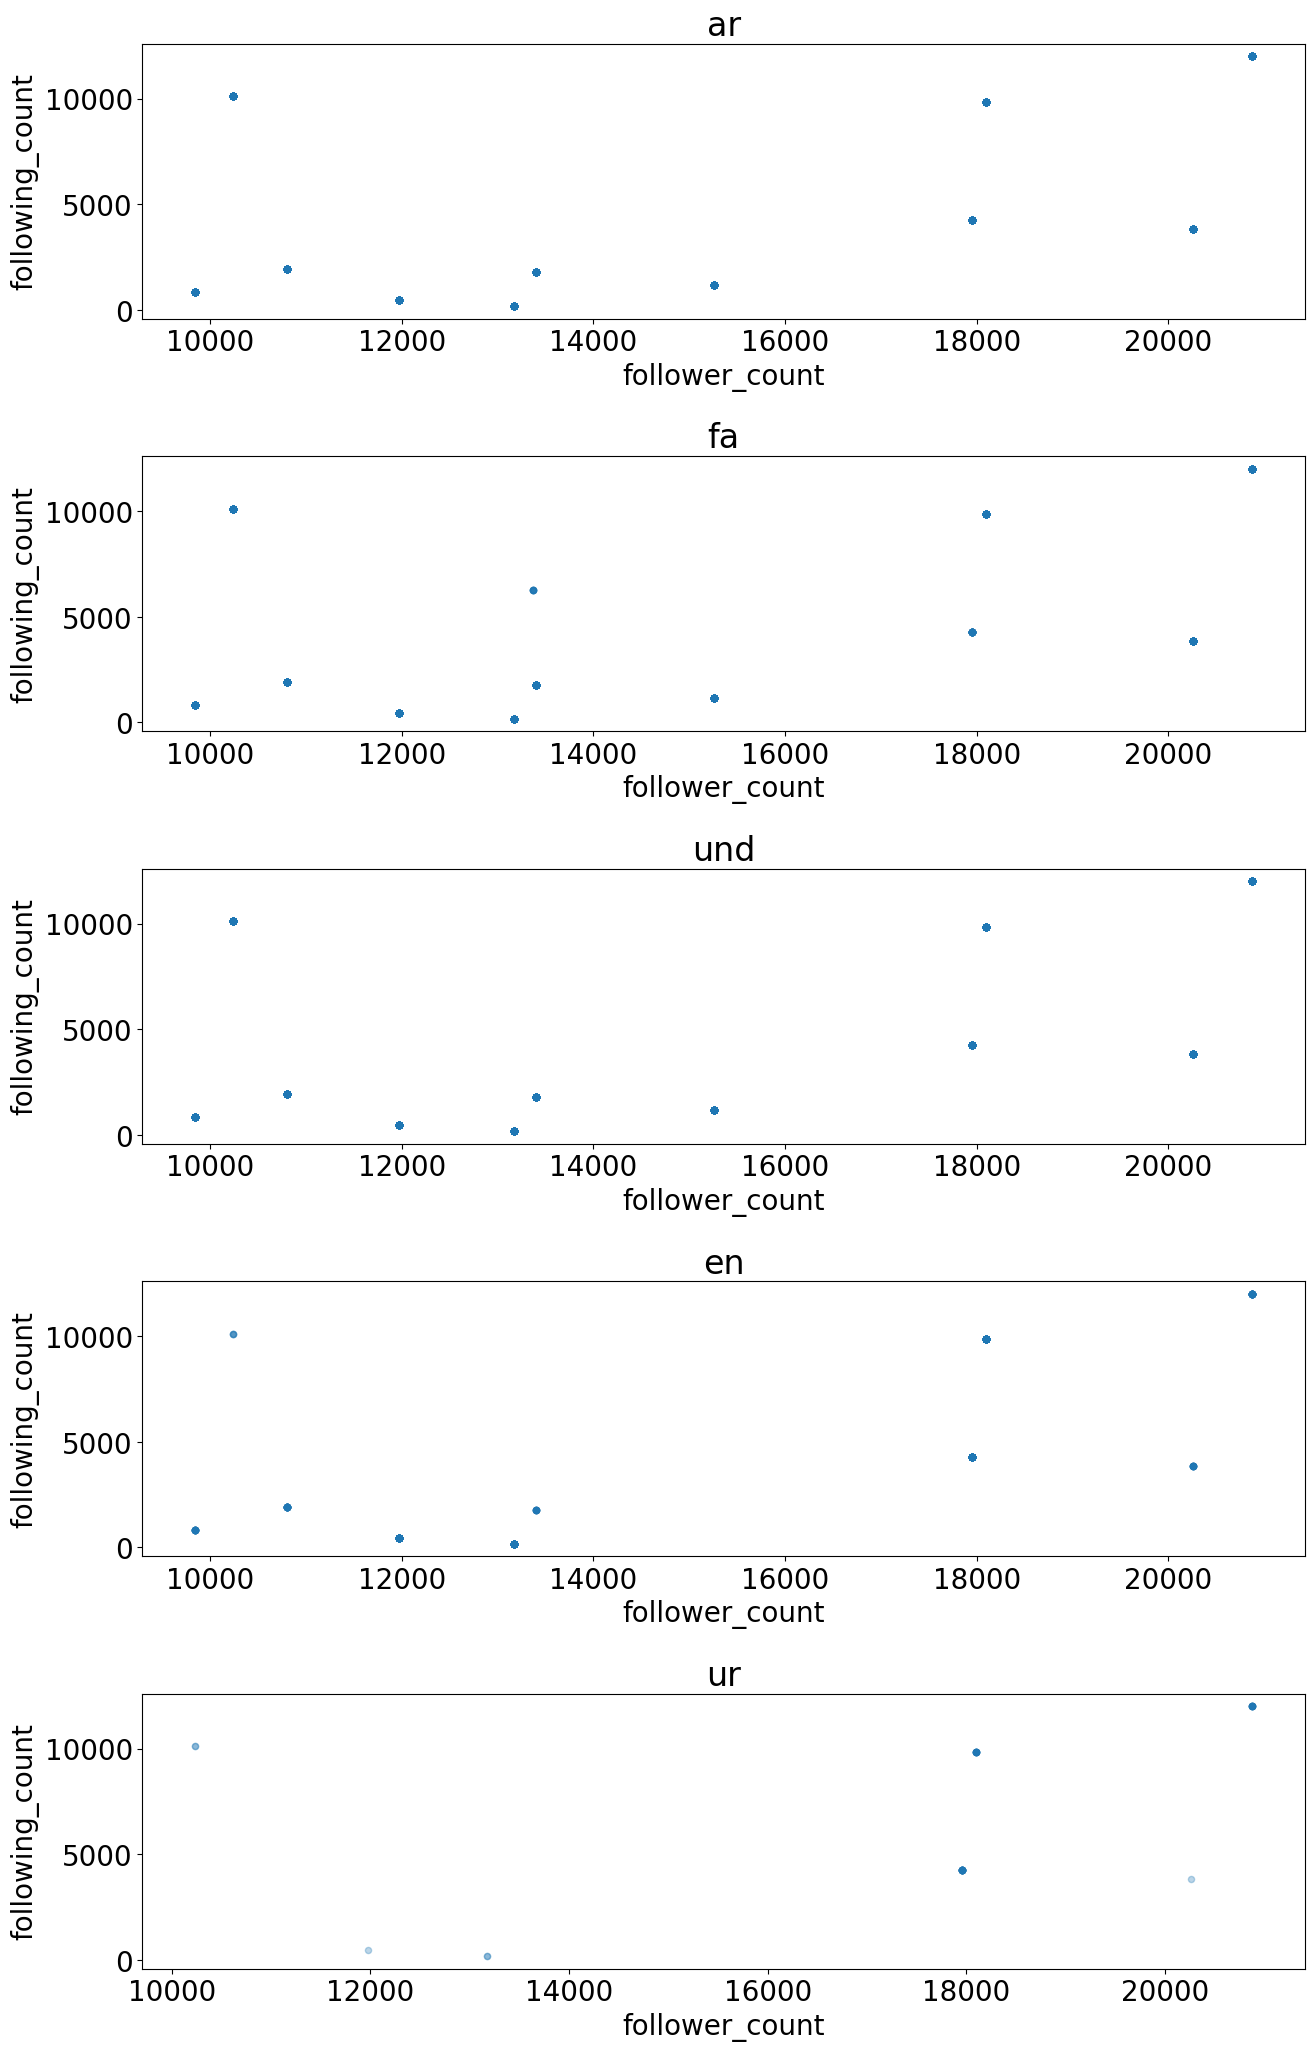

In [20]:
grouped_df = df.groupBy("tweet_language").count().orderBy(F.desc("count"))
top_languages_list = [row["tweet_language"] for row in grouped_df.limit(5).collect()]

# Create subplots
fig, axs = plt.subplots(nrows=5, figsize=(15, 25))
fig.subplots_adjust(hspace=0.5)

for i, language in enumerate(top_languages_list):
    # Filter the DataFrame for the specific language and select columns
    sub_df = df.filter(df.tweet_language == language).select("following_count", "follower_count")

    # Convert the filtered DataFrame to Pandas and plot the scatter
    sub_df_pandas = sub_df.toPandas()
    sub_df_pandas.plot.scatter(x='follower_count', y='following_count', ax=axs[i], alpha=0.3)
    axs[i].set_title(language)

plt.show()

8. Запрос для получения среднего количества подписчиков по датам регистрации в количестве пяти дат:

<Axes: xlabel='account_creation_date'>

Text(0.5, 1.0, 'Среднее количество подписчиков по дате создания учетной записи')

Text(0.5, 0, 'Дата создания уч. записи')

Text(0, 0.5, 'Среднее количество подписчиков')

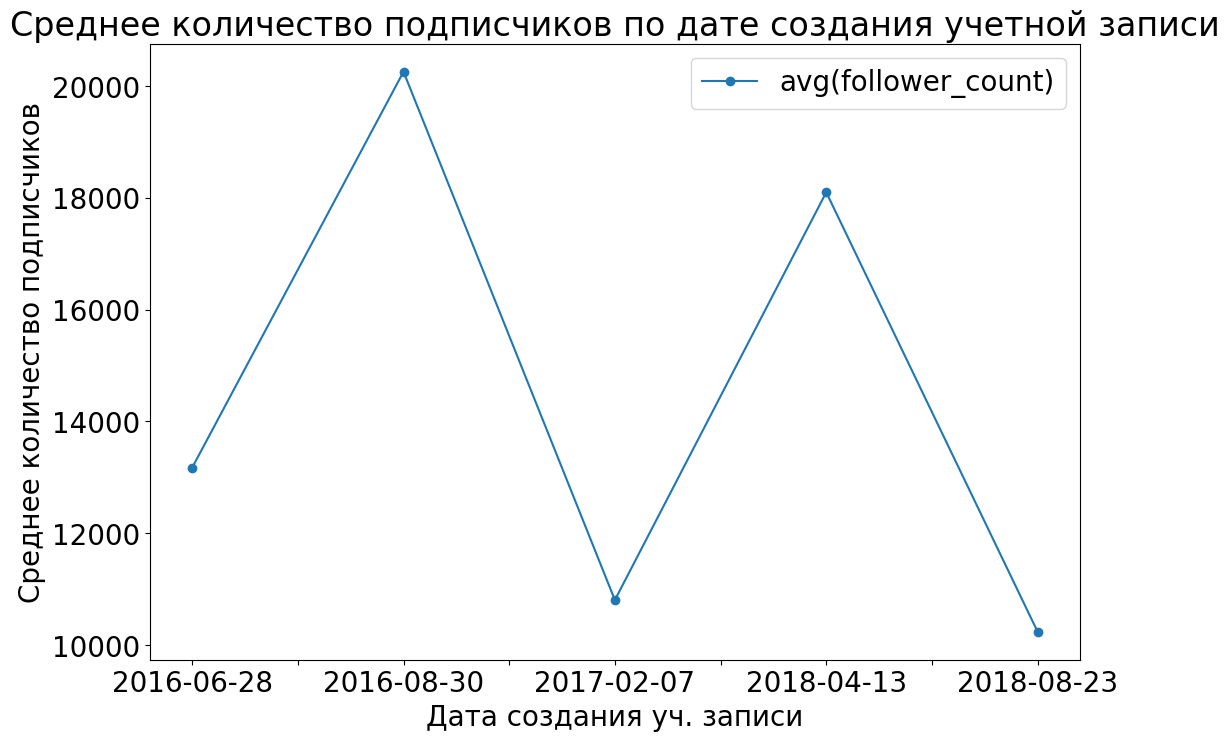

In [21]:
# Запрос для получения среднего количества подписчиков по датам регистрации
df = df.withColumn("account_creation_date", col("account_creation_date").cast(StringType()))
avg_follower_count_df = df.groupBy('account_creation_date').avg('follower_count').limit(5).toPandas()

# Сортировка данных по дате в обратном порядке и построение графика
avg_follower_count_df.sort_values(by='account_creation_date', ascending=True).plot(x='account_creation_date', y='avg(follower_count)', kind='line', marker='o', linestyle='-', figsize=(12, 8))
plt.title('Среднее количество подписчиков по дате создания учетной записи')
plt.xlabel('Дата создания уч. записи')
plt.ylabel('Среднее количество подписчиков')
plt.show()

df = df.withColumn("account_creation_date", col("account_creation_date").cast(DateType()))

9. Диаграмма рассеивания лайки-ретвиты по всем пользователям фрейма:

<Figure size 1100x700 with 0 Axes>

Text(0.5, 1.0, 'Диаграмма рассеивания количества лайков и количества ретвитов')

Text(0.5, 0, 'Количество лайков')

Text(0, 0.5, 'Количество ретвитов')

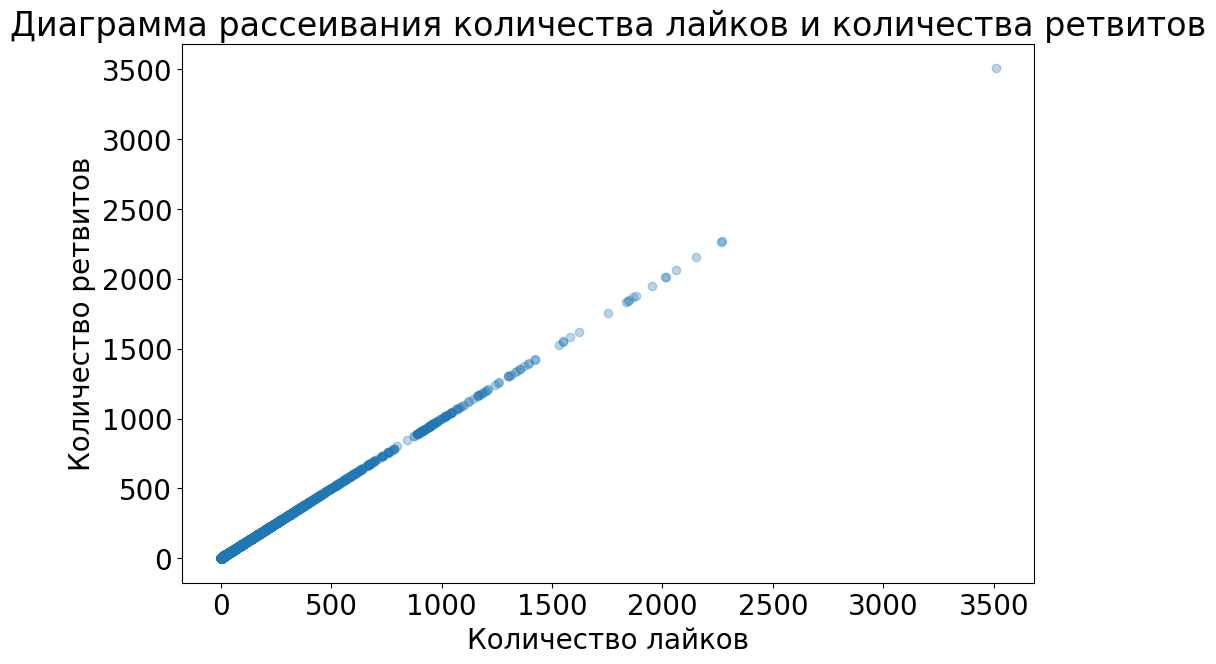

In [22]:
# Преобразование DataFrame в Pandas DataFrame
df_pd = df.select(df.like_count, df.retweet_count).toPandas()

# Построение диаграммы рассеяния
plt.figure(figsize=(11, 7))
plt.scatter(df_pd['like_count'], df_pd['retweet_count'], alpha=0.3)
plt.title('Диаграмма рассеивания количества лайков и количества ретвитов')
plt.xlabel('Количество лайков')
plt.ylabel('Количество ретвитов')
plt.show()

#### 6. Корреляций между признаками:

##### Поля "tweetid" и "userid" нет необходимости включать в списки для анализа корреляции. Идентификаторы обычно не имеют значения для анализа корреляций и могут даже помешать получению точных результатов.

##### Корреляция можно посчитать только у количественных признаков. В данной работе их шесть:
1. 'follower_count' - Количество подписчиков

2. 'following_count' - Количество подписок

3. 'quote_count' - Количество цитирований

4. 'reply_count' - Количество ответов

5. 'like_count' - Количество лайков

6. 'retweet_count' - Количество ретвитов

In [23]:
df.columns
print('Columns overview')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

['tweetid',
 'userid',
 'user_reported_location',
 'follower_count',
 'following_count',
 'account_creation_date',
 'tweet_language',
 'is_retweet',
 'quote_count',
 'reply_count',
 'like_count',
 'retweet_count']

Columns overview


,Column Name,Data type
0,tweetid,bigint
1,userid,bigint
2,user_reported_location,string
3,follower_count,int
4,following_count,int
5,account_creation_date,date
6,tweet_language,string
7,is_retweet,boolean
8,quote_count,int
9,reply_count,int


In [24]:
columns_to_exclude = ['tweetid', 'userid', 'user_reported_location', 'account_creation_date', 'tweet_language']
list_columns = [column for column in df.columns if column not in columns_to_exclude]
assembler = VectorAssembler(inputCols=list_columns, outputCol="features")
assembler.setHandleInvalid("skip")
df_vector = assembler.transform(df).select("features")

VectorAssembler_c68be3311288

In [25]:
matrix = Correlation.corr(df_vector, "features").collect()[0][0]
corrmatrix = matrix.toArray().tolist()
columns = ['follower_count', 'following_count', 'quote_count', 'reply_count', 'like_count', 'retweet_count']
df_corr = spark.createDataFrame(corrmatrix, columns)
df_corr.select(
    round('follower_count', 3).alias('follower_count'),
    round('following_count', 3).alias('following_count'),
    round('quote_count', 3).alias('quote_count'),
    round('reply_count', 3).alias('reply_count'),
    round('like_count', 3).alias('like_count'),
    round('retweet_count', 3).alias('retweet_count')
).show()

+--------------+---------------+-----------+-----------+----------+-------------+
|follower_count|following_count|quote_count|reply_count|like_count|retweet_count|
+--------------+---------------+-----------+-----------+----------+-------------+
|           1.0|          0.665|      0.493|     -0.086|    -0.086|       -0.086|
|         0.665|            1.0|      0.407|     -0.092|    -0.092|       -0.092|
|         0.493|          0.407|        1.0|     -0.124|    -0.124|       -0.124|
|        -0.086|         -0.092|     -0.124|        1.0|       1.0|          1.0|
|        -0.086|         -0.092|     -0.124|        1.0|       1.0|          1.0|
|        -0.086|         -0.092|     -0.124|        1.0|       1.0|          1.0|
|        -0.086|         -0.092|     -0.124|        1.0|       1.0|          1.0|
+--------------+---------------+-----------+-----------+----------+-------------+



##### Cильная связь имеется у признаков "follower_count (число подписчиков)" и "following_count (число подписок)". Это говорит о том, что при увеличении одного признака, другой, с большей вероятность будет увеличиваться. 
##### При увеличении признака "follower_count (число подписчиков)" признак "quote_count (число цитирований)" может быть увеличен. А при увеличении "following_count (число подписок) признак также может быть увеличен.
##### Обнаружено множество отрицательных корреляций.
##### У колонок "reply_count", "like_count", "retweet_count" корреляция между друг другом равна 1, т.к. данные по всем строкам датасета одиннаковы равны друг другу.
##### Корреляции "диагональных" признаков всегда равны 1, т.к. это и есть те же самые признаки и они всегда будут изменяться, если их изменяют.

### Сохранение результатов анализа:

##### Сохраним обработанный датасет для дальнейшей работы, а именно создания модели для машинного обучения:

In [26]:
df = df.withColumn("follower_count", col("follower_count").cast(DoubleType()))
df = df.withColumn("following_count", col("following_count").cast(DoubleType()))
df = df.withColumn("quote_count", col("like_count").cast(DoubleType()))
df = df.withColumn("reply_count", col("like_count").cast(DoubleType()))
df = df.withColumn("like_count", col("like_count").cast(DoubleType()))
df = df.withColumn("retweet_count", col("like_count").cast(DoubleType()))

processed_filename_data = "processed_" + filename_data
df.coalesce(1).write.option("header", "true").csv(processed_filename_data)

##### Проверим сохраненный датасет на сохранение типов признаков и количества строк:

In [27]:
df = spark.read.csv(processed_filename_data, header=True, mode="DROPMALFORMED", inferSchema=True)
print('Data overview')
df.printSchema()
print('Columns overview')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])
total_twitter_count = df.count()
print('Rows count:')
total_twitter_count

Data overview
root
 |-- tweetid: long (nullable = true)
 |-- userid: long (nullable = true)
 |-- user_reported_location: string (nullable = true)
 |-- follower_count: double (nullable = true)
 |-- following_count: double (nullable = true)
 |-- account_creation_date: date (nullable = true)
 |-- tweet_language: string (nullable = true)
 |-- is_retweet: boolean (nullable = true)
 |-- quote_count: double (nullable = true)
 |-- reply_count: double (nullable = true)
 |-- like_count: double (nullable = true)
 |-- retweet_count: double (nullable = true)

Columns overview


,Column Name,Data type
0,tweetid,bigint
1,userid,bigint
2,user_reported_location,string
3,follower_count,double
4,following_count,double
5,account_creation_date,date
6,tweet_language,string
7,is_retweet,boolean
8,quote_count,double
9,reply_count,double


Rows count:


133110

### Выводы:

##### В ходе лабораторной работы был изучен функционал Apache PySpark. Я научился пользоваться функционалом Apache Spark благодаря Python API - PySpark. Целью работы было провести разведочный анализ датасета. В ходе работы были выполнены данные пункты:
1. Типы признаков в датасете: Определил, какие данные включены в датасет (числовые, категориальные и бинарные).

2. Пропущенные значения и их устранения: Определил наличие пропущенных значений в данных и их устранил. Строки с пропущенными значениями было решено полностью удалить.

3. Выбросы и их устранения: Провел работу по устранению выбросов используя метод межквартильного интервала, а после проверил их отсутствие с помощью boxspot-ов.

4. Расчет статистических показателей признаков (средних, квартилей и т.д.): Провел расчёт статистических показателей категориальных, бинарных и числовых признаков, которые включают: средние значения, медианы, квартили, моды, стандартные отклонения, диапозоны значений, квантили, процентные соотношения и другие характеристики, чтобы лучше понять распределение данных.

5. Визуализация распределения наиболее важных признаков: Выполнил визуализацию и составил порядка 9 графиков. Визуализация помогает визуально оценить данные и выявить особенности.

6. Корреляция между признаками: Исследовал корреляции между признаками, позволяющие понять, какие признаки взаимосвязаны между собой, а какие – нет.

##### Разведочный анализ помогает лучше понять характеристики датасета, подготовить данные для построения моделей (для выполнения ЛР №2) и выявить интересные закономерности, которые могут стать основой для более глубокого исследования.